## Introduction
# HotpotQA: Understanding Multi-hop Question Answering

## Introduction

HotpotQA represents a significant advancement in question answering research. Created in 2018 by researchers from Carnegie Mellon University, Stanford University, and Université de Montréal, this dataset was specifically designed to address limitations in existing question answering systems and push the boundaries of AI reasoning capabilities.

## Why HotpotQA Was Created

HotpotQA was developed to address several critical limitations in existing question answering datasets:

1. **Limited Reasoning Capabilities**: Prior QA datasets primarily tested single-hop reasoning, where answers could be found in a single paragraph or even a single sentence.

2. **Lack of Explainability**: Most QA systems couldn't explain how they arrived at answers, functioning as "black boxes."

3. **Constrained by Knowledge Bases**: Many multi-hop datasets were built on structured knowledge bases with predefined schemas, limiting question diversity.

4. **Insufficient Supervision**: Previous datasets provided only distant supervision (just the final answer), making it difficult for models to learn reasoning processes.

## Key Features of HotpotQA

HotpotQA introduced several innovations:

1. **Multi-hop Reasoning**: Questions require finding and connecting information across multiple documents, mimicking how humans research complex topics.

2. **Natural Language Diversity**: Not constrained by knowledge base schemas, allowing for more natural and diverse questions.

3. **Supporting Facts Annotation**: Provides sentence-level supporting facts required for reasoning, enabling stronger supervision and explainable predictions.

4. **Comparison Questions**: Introduces a new type of question that requires comparing attributes of different entities.

## Dataset Composition

- **Size**: Approximately 113,000 question-answer pairs
- **Source**: Based on Wikipedia articles
- **Question Types**: 
  - Bridge questions (requiring finding intermediate entities)
  - Comparison questions (comparing attributes of entities)
- **Difficulty Levels**: Easy, Medium, Hard
- **Benchmark Settings**:
  - Distractor setting (10 paragraphs with 2 gold paragraphs)
  - Full wiki setting (search entire Wikipedia)

## Educational Implications

HotpotQA is particularly valuable for teaching:

1. **Complex Reasoning**: Students can develop step-by-step reasoning skills by understanding how to connect information from multiple sources.

2. **Information Synthesis**: The dataset demonstrates how to combine facts from different documents to arrive at new conclusions.

3. **Critical Evaluation**: By examining supporting facts, students learn to identify which pieces of information are relevant to answering questions.

4. **Explainable AI**: The supporting facts annotation helps teach the importance of explainability in AI systems.

## Example Question Types

### Bridge Questions

These questions require finding an intermediate entity (bridge) that connects information from two documents.

**Example**: 
> "The Oberoi family is part of a hotel company that has a head office in what city?"

This requires first finding that the Oberoi family is connected to "The Oberoi Group" (bridge entity), then discovering where the Oberoi Group headquarters is located.

### Comparison Questions

These questions require comparing attributes of different entities.

**Example**:
> "Were Pavel Urysohn and Leonid Levin both mathematicians?"

This requires finding information about both individuals and comparing their professions.

## Challenges and Impact

HotpotQA has become a benchmark for evaluating the reasoning capabilities of QA systems. Performance on this dataset measures a system's ability to:

1. Find relevant documents
2. Identify supporting facts
3. Connect information across documents
4. Provide accurate answers
5. Explain the reasoning process

The creation of HotpotQA has inspired numerous advances in multi-hop reasoning models and continues to influence the development of more sophisticated question answering systems.

## Resources for Further Learning

- [Official HotpotQA Website](https://hotpotqa.github.io/)
- [HotpotQA on Hugging Face](https://huggingface.co/datasets/hotpotqa/hotpot_qa)
- [GitHub Repository](https://github.com/hotpotqa/hotpot)

---

*This document is intended for educational purposes to understand the significance of HotpotQA in advancing question answering research and applications.*

In [11]:
# uv venv && source .venv/bin/activate
%pip install -q datasets transformers pytorch-lightning matplotlib seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset

def load_hotpotqa_dataset():
    """
    Load the HotpotQA dataset from the Hugging Face datasets library.
    Returns the dataset object.
    """
    try:
        dataset = load_dataset("hotpot_qa", "distractor")
        print("Successfully loaded HotpotQA dataset!")
        return dataset
    except Exception as e:
        print(f"Error loading dataset: {e}")
        print("Please ensure you have the 'datasets' library installed.")
        return None

# Load the dataset
hotpotqa = load_hotpotqa_dataset()

Successfully loaded HotpotQA dataset!


In [13]:
def explore_dataset_structure(dataset):
    """
    Print basic information about the dataset structure.
    """
    if dataset is None:
        print("No dataset to explore.")
        return
    
    # Show available splits
    print(f"Dataset splits: {list(dataset.keys())}")
    
    # Show split sizes
    for split in dataset.keys():
        print(f"Size of {split} split: {len(dataset[split])}")
    
    # Look at column names (features)
    print(f"\nDataset features: {dataset['train'].features}")
    
    # Get a sample from the training set
    sample = dataset['train'][0]
    
    # Print out the structure of the sample
    print("\nSample structure:")
    for key in sample:
        value = sample[key]
        
        if isinstance(value, list):
            print(f"{key}: List with {len(value)} items")
            # If the list has elements, show the first one
            if len(value) > 0:
                if key == "context":
                    print(f"  First item: Title = '{value[0][0]}', with {len(value[0][1])} sentences")
                elif key == "supporting_facts":
                    print(f"  Format: [document_title, sentence_id]")
                    if len(value) > 0:
                        print(f"  First item: {value[0]}")
                else:
                    print(f"  First item type: {type(value[0])}")
        else:
            print(f"{key}: {type(value)}")
            if isinstance(value, str):
                if len(value) > 70:
                    print(f"  Value (truncated): {value[:70]}...")
                else:
                    print(f"  Value: {value}")
    
    return sample

# Explore the dataset structure
sample = explore_dataset_structure(hotpotqa)

Dataset splits: ['train', 'validation']
Size of train split: 90447
Size of validation split: 7405

Dataset features: {'id': Value(dtype='string', id=None), 'question': Value(dtype='string', id=None), 'answer': Value(dtype='string', id=None), 'type': Value(dtype='string', id=None), 'level': Value(dtype='string', id=None), 'supporting_facts': Sequence(feature={'title': Value(dtype='string', id=None), 'sent_id': Value(dtype='int32', id=None)}, length=-1, id=None), 'context': Sequence(feature={'title': Value(dtype='string', id=None), 'sentences': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}, length=-1, id=None)}

Sample structure:
id: <class 'str'>
  Value: 5a7a06935542990198eaf050
question: <class 'str'>
  Value: Which magazine was started first Arthur's Magazine or First for Women?
answer: <class 'str'>
  Value: Arthur's Magazine
type: <class 'str'>
  Value: comparison
level: <class 'str'>
  Value: medium
supporting_facts: <class 'dict'>
context: <class 'dict'>


Dataset splits analysis:

TRAIN split:
  Size: 90447 examples
  Yes/No questions: approximately 5.90%
  Question types:
    medium: 607 sampled examples (60.70%)
    hard: 179 sampled examples (17.90%)
    easy: 214 sampled examples (21.40%)

VALIDATION split:
  Size: 7405 examples
  Yes/No questions: approximately 5.90%
  Question types:
    hard: 1000 sampled examples (100.00%)


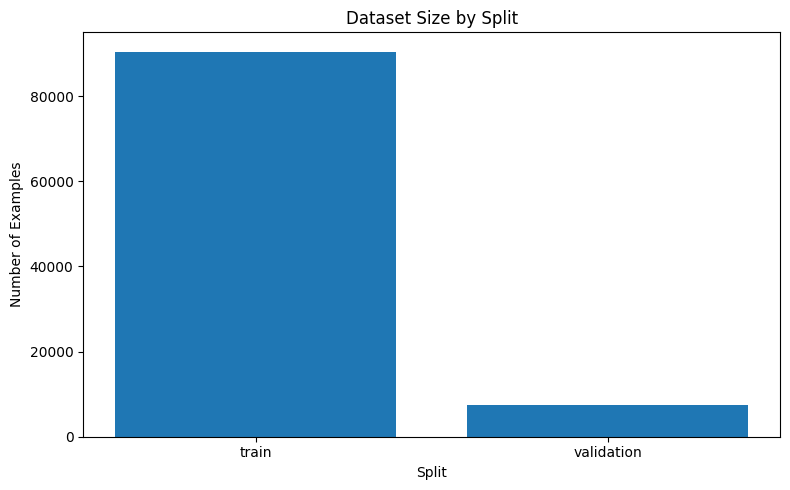

In [14]:
def examine_dataset_splits(dataset):
    """
    Analyze how the dataset is divided and what each split contains.
    """
    if dataset is None:
        print("No dataset to examine.")
        return
    
    # Get information about each split
    split_info = {}
    for split in dataset.keys():
        split_data = dataset[split]
        
        # Count question types (based on "level" field)
        question_types = {}
        for i in range(min(1000, len(split_data))):  # Sample the first 1000 examples
            example = split_data[i]
            q_type = example.get('level', 'Not specified')
            if q_type not in question_types:
                question_types[q_type] = 0
            question_types[q_type] += 1
        
        # Count yes/no questions
        yes_no_count = 0
        for i in range(min(1000, len(split_data))):  # Sample the first 1000 examples
            example = split_data[i]
            if example['answer'].lower() in ['yes', 'no']:
                yes_no_count += 1
        
        # Estimate percentage of yes/no questions
        if len(split_data) > 0:
            yes_no_percent = yes_no_count / min(1000, len(split_data)) * 100
        else:
            yes_no_percent = 0
        
        # Store information about the split
        split_info[split] = {
            'size': len(split_data),
            'question_types': question_types,
            'yes_no_question_percent': yes_no_percent,
        }
    
    # Display the information
    print("Dataset splits analysis:")
    for split, info in split_info.items():
        print(f"\n{split.upper()} split:")
        print(f"  Size: {info['size']} examples")
        print(f"  Yes/No questions: approximately {info['yes_no_question_percent']:.2f}%")
        
        if isinstance(info['question_types'], dict) and info['question_types']:
            print("  Question types:")
            for q_type, count in info['question_types'].items():
                percent = count/min(1000, info['size'])*100
                print(f"    {q_type}: {count} sampled examples ({percent:.2f}%)")
    
    # Plot the split sizes
    plt.figure(figsize=(8, 5))
    plt.bar(split_info.keys(), [info['size'] for info in split_info.values()])
    plt.title('Dataset Size by Split')
    plt.xlabel('Split')
    plt.ylabel('Number of Examples')
    plt.tight_layout()
    plt.show()
    
    return split_info

# Examine how the dataset is divided
split_info = examine_dataset_splits(hotpotqa)

In [15]:
def view_random_examples(dataset, split='train', n=3, max_docs=10, max_sentences=10):
    """
    Display n random examples from the specified split,
    handling different data formats in the dataset.
    
    Args:
        dataset: The HotpotQA dataset
        split: Dataset split to sample from ('train', 'validation', etc.)
        n: Number of examples to display
        max_docs: Maximum number of documents to display per example
        max_sentences: Maximum number of sentences to display per document
    
    Returns:
        List of the randomly selected indices
    """
    if dataset is None:
        print("No dataset to view examples from.")
        return
    
    if split not in dataset:
        print(f"Split '{split}' not found in dataset.")
        return
    
    # Get random indices
    import random
    split_data = dataset[split]
    total_examples = len(split_data)
    random_indices = random.sample(range(total_examples), min(n, total_examples))
    
    # Display the random examples
    for i, idx in enumerate(random_indices):
        example = split_data[idx]
        
        print(f"\n=== Example {i+1} (index {idx}) ===")
        print(f"Question: {example['question']}")
        print(f"Answer: {example['answer']}")
        
        # Display supporting facts
        print("\nSupporting facts:")
        supporting_facts = example['supporting_facts']
        
        # Handle different formats of supporting facts
        if isinstance(supporting_facts, list):
            # List format [doc_title, sent_id]
            for fact in supporting_facts:
                if isinstance(fact, list) and len(fact) >= 2:
                    print(f"  - Document: '{fact[0]}', Sentence ID: {fact[1]}")
                else:
                    print(f"  - {fact}")
        elif isinstance(supporting_facts, dict):
            # Dictionary format {'title': [...], 'sent_id': [...]}
            titles = supporting_facts.get('title', [])
            sent_ids = supporting_facts.get('sent_id', [])
            
            if len(titles) == len(sent_ids):
                for t, s in zip(titles, sent_ids):
                    print(f"  - Document: '{t}', Sentence ID: {s}")
            else:
                print(f"  - Titles: {titles}")
                print(f"  - Sentence IDs: {sent_ids}")
        else:
            print(f"  - Unknown format: {supporting_facts}")
        
        # Display context
        print("\nContext:")
        context = example['context']
        
        # Handle different formats of context
        if isinstance(context, list):
            # List format of [doc_title, sentences]
            display_count = min(len(context), max_docs)
            for doc_idx, doc in enumerate(context[:display_count]):
                if isinstance(doc, list) and len(doc) >= 2:
                    title = doc[0]
                    sentences = doc[1]
                    print(f"\nDocument: '{title}'")
                    
                    # Print sentences up to max_sentences
                    sentences_display_count = min(len(sentences), max_sentences)
                    for sent_idx, sentence in enumerate(sentences[:sentences_display_count]):
                        print(f"  Sentence {sent_idx}: {sentence}")
                    
                    if len(sentences) > sentences_display_count:
                        print(f"  ... ({len(sentences) - sentences_display_count} more sentences)")
                else:
                    print(f"\nDocument {doc_idx+1}: {doc}")
            
            if len(context) > display_count:
                print(f"\n... ({len(context) - display_count} more documents)")
        
        elif isinstance(context, dict):
            # Dictionary format {'title': [...], 'sentences': [[...]]}
            titles = context.get('title', [])
            sentences_list = context.get('sentences', [])
            
            display_count = min(len(titles), max_docs)
            for doc_idx, (title, sentences) in enumerate(zip(titles[:display_count], sentences_list[:display_count])):
                print(f"\nDocument: '{title}'")
                
                # Print sentences up to max_sentences
                sentences_display_count = min(len(sentences), max_sentences)
                for sent_idx, sentence in enumerate(sentences[:sentences_display_count]):
                    print(f"  Sentence {sent_idx}: {sentence}")
                
                if len(sentences) > sentences_display_count:
                    print(f"  ... ({len(sentences) - sentences_display_count} more sentences)")
            
            if len(titles) > display_count:
                print(f"\n... ({len(titles) - display_count} more documents)")
        
        else:
            print(f"  Unknown format: {context}")
        
        print("\n" + "="*50)
    
    return random_indices

# Example usage:
# View 2 random examples with up to 10 documents and 10 sentences per document
random_indices = view_random_examples(hotpotqa, split='train', n=2, max_docs=10, max_sentences=10)

# View 1 random example with more limited output (3 documents, 5 sentences each)
# random_indices = view_random_examples(hotpotqa, split='train', n=1, max_docs=3, max_sentences=5)


=== Example 1 (index 60791) ===
Question: Which was an animated film, Tuck Everlasting or Saludos Amigos?
Answer: Saludos Amigos

Supporting facts:
  - Document: 'Tuck Everlasting (2002 film)', Sentence ID: 0
  - Document: 'Saludos Amigos', Sentence ID: 0

Context:

Document: 'Tuck Everlasting (musical)'
  Sentence 0: Tuck Everlasting is a musical based upon the American children's novel "Tuck Everlasting" by Natalie Babbitt.
  Sentence 1:  It features music by Chris Miller, lyrics by Nathan Tysen and a book by Claudia Shear and Tim Federle, with direction and choreography by Casey Nicholaw.
  Sentence 2:  The musical had its premiere at the Alliance Theater in Atlanta, Georgia, in 2015.
  Sentence 3:  It began Broadway previews on March 31, 2016; and opened on April 26, 2016, at the Broadhurst Theatre, in New York City.
  Sentence 4:  The production closed on May 29, 2016, after 39 performances.

Document: 'Michael Park (actor)'
  Sentence 0: Michael Frank Park (born July 20, 1968) i